# Dynamic Topic Models 
Este notebook es una adaptación del tutorial "Dynamic Topic Models en el contexto del estallido social en Chile" preparado por Matthieu Vernier para EVIC2019

# 1. Definición del Dataset y de sus _Slices_

In [1]:
import pandas as pd
from pandasql import sqldf #para utilizar una síntaxis SQL para consultar nuestros datos

La carpeta _datasets_ contiene un archivo CSV llamado 'dataset_eldinamo_13122019.csv'. Corresponde a un dataset de noticias del medio "El Dinamo" entre el 4 de octubre 2019 y el 13 de diciembre 2019.

In [3]:
dataset="dataset_eldinamo_13122019.csv"
df = pd.read_csv(dataset)
df[:5]

,url,date,text
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,13 de Diciembre de 2019,El ministro de Vivienda Cristián Monckeberg ...
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,13 de Diciembre de 2019,La Moneda informó que Sebastián Piñera decretó...
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,13 de Diciembre de 2019,La Corte de apelaciones de Santiago declaró ad...
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Luego que durante esta mañana la Organización ...
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,13 de Diciembre de 2019,Tras varias semanas de espera la misión de ob...


In [4]:
print("Número de documentos: "+str(df.count()[0]))

Número de documentos: 453


Cambiamos el formato de las fechas para poder utilizar la información más facilmente.

In [5]:
#Modificar la columna "date" para que sea reconocida como fecha y no como texto.
df['date']= df['date'].replace(" de Diciembre de ", "/12/",regex=True)
df['date']= df['date'].replace(" de Noviembre de ", "/11/",regex=True)
df['date']= df['date'].replace(" de Octubre de ", "/10/",regex=True) 
df['date'] =pd.to_datetime(df['date'],format="%d/%m/%Y").dt.date

Para definir cómo dividir el dataset en distintos periodos de tiempo, miremos primero cuántos documentos tenemos y cómo se distribuyen en el tiempo:

In [6]:
#Contar el número de documentos por fecha
query="""SELECT date as fecha,count(*) as documentos
FROM df GROUP BY date;"""
result=sqldf(query)
result

,fecha,documentos
0,2019-10-04,2
1,2019-10-05,3
2,2019-10-06,3
3,2019-10-07,8
4,2019-10-08,5
...,...,...
66,2019-12-09,6
67,2019-12-10,6
68,2019-12-11,8
69,2019-12-12,7


En este ejemplo, divideremos los datos en cinco segmentos de dos semanas:

In [7]:
# libraries
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
plt.rcParams['figure.figsize'] = [24, 12]

time_plot = sns.lineplot(x='fecha',
                         y='documentos',
                         data=result
                         ).set_title('Número de documentos por día')
plt.xticks(rotation=70)
plt.tick_params(labelsize=12)

plt.axvline(x='2019-10-04',color='red')
plt.axvline(x='2019-10-18',color='red')
plt.axvline(x='2019-11-01',color='red')
plt.axvline(x='2019-11-15',color='red')
plt.axvline(x='2019-11-29',color='red')
plt.axvline(x='2019-12-13',color='red')

plt.show()

<Figure size 2400x1200 with 1 Axes>

In [11]:
q="""SELECT 'Week 1',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-10-04" AND "2019-10-17"
UNION
SELECT 'Week 2',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-10-18" AND "2019-10-31"
UNION
SELECT 'Week 3',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-01" AND "2019-11-15"
UNION
SELECT 'Week 4',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-16" AND "2019-11-29"
UNION
SELECT 'Week 5',count(*) as 'Number of documents'
FROM df WHERE date BETWEEN "2019-11-30" AND "2019-12-13"
;"""
result=sqldf(q)
result

,'Week 1',Number of documents
0,Week 1,76
1,Week 2,119
2,Week 3,96
3,Week 4,84
4,Week 5,78


Para identificar los _slices_, conservamos el número de documentos por cada segmento:

In [8]:
index_slices=[76,119,96,84,78]

# 2. Preprocesamientos: filtrar palabras según categoría gramatical y/o extraer palabras claves

In [9]:
import spacy
nlp = spacy.load('es_core_news_md', disable=['parser','ner','textcat','...'] )

In [10]:
def getNouns(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        filteredText=""
        
        tokens = nlp(text)
        
        for token in tokens:
            if token.pos_ == "NOUN" :
                filteredText=filteredText+" "+str(token.text.lower().strip())
                
        dataFrame.loc[index,'nouns']=filteredText

In [11]:
%%time
getNouns(df,"text")

Wall time: 9.49 s


In [12]:
#Código from: https://towardsdatascience.com/textrank-for-keyword-extraction-by-python-c0bae21bcec0

from collections import OrderedDict
import numpy as np

from spacy.lang.es.stop_words import STOP_WORDS

nlp.add_pipe(nlp.create_pipe('sentencizer'))

class TextRank4Keyword():
    """Extract keywords from text"""
    
    def __init__(self):
        self.d = 0.85 # damping coefficient, usually is .85
        self.min_diff = 1e-5 # convergence threshold
        self.steps = 10 # iteration steps
        self.node_weight = None # save keywords and its weight

    
    def set_stopwords(self, stopwords):  
        """Set stop words"""
        for word in STOP_WORDS.union(set(stopwords)):
            lexeme = nlp.vocab[word]
            lexeme.is_stop = True
    
    def sentence_segment(self, doc, candidate_pos, lower):
        """Store those words only in cadidate_pos"""
        sentences = []
        for sent in doc.sents:
            selected_words = []
            for token in sent:
                # Store words only with cadidate POS tag
                if token.pos_ in candidate_pos and token.is_stop is False:
                    if lower is True:
                        selected_words.append(token.text.lower())
                    else:
                        selected_words.append(token.text)
            sentences.append(selected_words)
        return sentences
        
    def get_vocab(self, sentences):
        """Get all tokens"""
        vocab = OrderedDict()
        i = 0
        for sentence in sentences:
            for word in sentence:
                if word not in vocab:
                    vocab[word] = i
                    i += 1
        return vocab
    
    def get_token_pairs(self, window_size, sentences):
        """Build token_pairs from windows in sentences"""
        token_pairs = list()
        for sentence in sentences:
            for i, word in enumerate(sentence):
                for j in range(i+1, i+window_size):
                    if j >= len(sentence):
                        break
                    pair = (word, sentence[j])
                    if pair not in token_pairs:
                        token_pairs.append(pair)
        return token_pairs
        
    def symmetrize(self, a):
        return a + a.T - np.diag(a.diagonal())
    
    def get_matrix(self, vocab, token_pairs):
        """Get normalized matrix"""
        # Build matrix
        vocab_size = len(vocab)
        g = np.zeros((vocab_size, vocab_size), dtype='float')
        for word1, word2 in token_pairs:
            i, j = vocab[word1], vocab[word2]
            g[i][j] = 1
            
        # Get Symmeric matrix
        g = self.symmetrize(g)
        
        # Normalize matrix by column
        norm = np.sum(g, axis=0)
        g_norm = np.divide(g, norm, where=norm!=0) # this is ignore the 0 element in norm
        
        return g_norm

    
    def get_keywords(self, number=10):
        """Print top number keywords"""
        l_keywords = []
        node_weight = OrderedDict(sorted(self.node_weight.items(), key=lambda t: t[1], reverse=True))
        for i, (key, value) in enumerate(node_weight.items()):
            #print(key + ' - ' + str(value))
            l_keywords.append( (key, value) )
            if i > number:
                break
        return l_keywords
        
        
    def analyze(self, text, 
                candidate_pos=['NOUN', 'PROPN'], 
                window_size=4, lower=False, stopwords=list()):
        """Main function to analyze text"""
        
        # Set stop words
        self.set_stopwords(stopwords)
        
        # Pare text by spaCy
        doc = nlp(text) #, disable=['parser'])
        
        # Filter sentences
        sentences = self.sentence_segment(doc, candidate_pos, lower) # list of list of words
        
        # Build vocabulary
        vocab = self.get_vocab(sentences)
        
        # Get token_pairs from windows
        token_pairs = self.get_token_pairs(window_size, sentences)
        
        # Get normalized matrix
        g = self.get_matrix(vocab, token_pairs)
        
        # Initionlization for weight(pagerank value)
        pr = np.array([1] * len(vocab))
        
        # Iteration
        previous_pr = 0
        for epoch in range(self.steps):
            pr = (1-self.d) + self.d * np.dot(g, pr)
            if abs(previous_pr - sum(pr))  < self.min_diff:
                break
            else:
                previous_pr = sum(pr)

        # Get weight for each node
        node_weight = dict()
        for word, index in vocab.items():
            node_weight[word] = pr[index]
        
        self.node_weight = node_weight

In [14]:
def getKeywords(dataFrame,columnName):
    
    for index,rows in dataFrame.iterrows():
        
        text=rows[columnName]
        
        keywords=""
        
        tr4w = TextRank4Keyword()
        tr4w.analyze(text, candidate_pos = ['NOUN'], window_size=4, lower=False)
    
        tokens = tr4w.get_keywords(20)

        for token in tokens:

            keywords=keywords+" "+str(token[0])
                
        dataFrame.loc[index,'keywords']=keywords

In [15]:
%%time
getKeywords(df,"text")

Wall time: 9.87 s


In [24]:
df[:5]

,url,date,text,nouns,keywords
0,https://www.eldinamo.cl/nacional/2019/12/13/mo...,2019-12-13,El ministro de Vivienda Cristián Monckeberg ...,ministro investigación cabo caso corrupción i...,funcionarios delitos hechos corrupción person...
1,https://www.eldinamo.cl/nacional/2019/12/13/go...,2019-12-13,La Moneda informó que Sebastián Piñera decretó...,días accidente saldo víctimas mensaje apoyo s...,víctimas sedes pasajeros familiares cuerpos t...
2,https://www.eldinamo.cl/nacional/2019/12/13/co...,2019-12-13,La Corte de apelaciones de Santiago declaró ad...,apelaciones querella intendente dirigente inc...,libertad dirigente resolución expresión derec...
3,https://www.eldinamo.cl/nacional/2019/12/13/in...,2019-12-13,Luego que durante esta mañana la Organización ...,mañana informe situación estallido reacciones...,informe violencia violaciones reparación ofic...
4,https://www.eldinamo.cl/nacional/2019/12/13/in...,2019-12-13,Tras varias semanas de espera la misión de ob...,semanas espera misión observadores informe es...,informe personas derechos forma manifestacion...


# 4. Representación vectorial de los documentos

Utilizaremos la columna "keywords" como simplificación de los documentos.

In [16]:
from gensim.models import TfidfModel
from gensim.corpora import Dictionary

documents=list(df['keywords'])
documents=[x.split(" ") for x in documents]

dictionary = Dictionary(documents)

#dictionary.filter_extremes(no_below=0,no_above=0.99)

dictionary.filter_n_most_frequent(1)

corpus = [dictionary.doc2bow(doc) for doc in documents] 

model = TfidfModel(corpus)

vectorizedCorpus = model[corpus]

## 3. Optimización de modelos de tópicos dinámicos

Comenzaremos estimando el modelo con 3 tópicos y veremos la convergencia con ayuda del log de la verosimilitud (del modelo aproximado) con todos los datos.

In [25]:
from gensim.models import ldaseqmodel
from gensim.models import LdaSeqModel
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=index_slices, 
                                 num_topics=3,
                                 chain_variance=0.05,
                                 alphas=0.9,
                                 passes=10,
                                 chunksize=50,
                                 em_min_iter=6,
                                 em_max_iter=10)

lver = []
niter = [10,20,30, 40,50,75,100]
for i in range(7):
    ll= ldaseq.fit_lda_seq(corpus=corpus, 
                   lda_inference_max_iter=niter[i], 
                   em_min_iter =6, 
                   em_max_iter =10, 
                   chunksize=50)
    lver.append(ll)


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)
C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


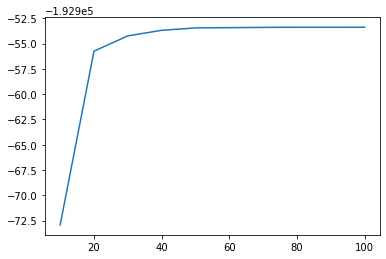

In [26]:
import matplotlib.pyplot as plt
niter = [10,20,30, 40,50,75,100]
plt.plot(niter[0:7],lver[0:7])

**Ejercicio 1:**
Investigue el rol de los parámetros de entrada de la clase LdaSeqModel, sus valores por omisión y cuales son los criterios para modificar dichos valores.


Entrenamos modelos con k_topics entre 3 y 10, y guardamos los modelos en archivos.

In [27]:
%%time
from IPython.display import Audio
import numpy as np

from gensim.models import ldaseqmodel
from gensim.corpora import Dictionary, bleicorpus
from gensim.matutils import hellinger
from gensim.models.coherencemodel import CoherenceModel
from gensim.test.utils import common_corpus
from gensim.test.utils import datapath

import time

k_topics=3
DTM_models = []
for i in range(8):

    
    init=time.time()

    s=time.time()

    ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=index_slices, 
                                 num_topics=k_topics+i,
                                 chain_variance=0.1,
                                 alphas=0.9,
                                 passes=40,
                                 chunksize=50,
                                 em_min_iter=6,
                                 em_max_iter=20)

    DTM_models.append(ldaseq)

    e=time.time()
    print(str(k_topics+i)+" Topics - Tiempo necesario para la optimización del modelo:",(e-s))

    end=time.time()
    #print(end-init)
    
    #se guarda el modelo
    path_of_model = datapath("D:/model_"+str(k_topics+i)+"_topics")
    print(path_of_model)
    ldaseq.save(path_of_model)

C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


3 Topics - Tiempo necesario para la optimización del modelo: 174.25915503501892
D:/model_3_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


4 Topics - Tiempo necesario para la optimización del modelo: 211.93650341033936
D:/model_4_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


5 Topics - Tiempo necesario para la optimización del modelo: 247.05357718467712
D:/model_5_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


6 Topics - Tiempo necesario para la optimización del modelo: 274.448370218277
D:/model_6_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


7 Topics - Tiempo necesario para la optimización del modelo: 307.48544907569885
D:/model_7_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


8 Topics - Tiempo necesario para la optimización del modelo: 346.34604573249817
D:/model_8_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


9 Topics - Tiempo necesario para la optimización del modelo: 372.4319517612457
D:/model_9_topics


C:\ProgramData\Anaconda3\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


10 Topics - Tiempo necesario para la optimización del modelo: 392.5206756591797
D:/model_10_topics
Wall time: 38min 46s


# 4. Evaluación de los modelos

In [28]:
from gensim.models import LdaSeqModel
from gensim.models.coherencemodel import CoherenceModel

k_topics=3

cv=list()
umass =list()
cuci = list()
cnpmi = list()

for i in range(8):
    #path_of_model = datapath("D:/model_"+str(k_topics+i)+"_topics")
    ldaseq = LdaSeqModel.load("D:/model_"+str(k_topics+i)+"_topics")
    
    values_cv=list()
    values_umass = list()
    values_cuci = list()
    values_cnpmi = list()
    
    for time_fragment in range(5):
        topics_wrapper = ldaseq.dtm_coherence(time=time_fragment)
        cm_wrapper_cv = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_v')
        cm_wrapper_umass = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='u_mass')
        cm_wrapper_cuci = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_uci')
        cm_wrapper_cnpmi = CoherenceModel(topics=topics_wrapper, texts=documents, dictionary=dictionary, coherence='c_npmi')
        values_cv.append(cm_wrapper_cv.get_coherence())
        values_umass.append(cm_wrapper_umass.get_coherence())
        values_cuci.append(cm_wrapper_cuci.get_coherence())
        values_cnpmi.append(cm_wrapper_cnpmi.get_coherence())
    
    average_cv = sum(values_cv) / len(values_cv) 
    average_umass= sum(values_umass) / len(values_umass)
    average_cuci = sum(values_cuci) / len(values_cuci)
    average_cnpmi = sum(values_cnpmi) / len(values_cnpmi)
    cv.append(average_cv)
    umass.append(average_umass)
    cuci.append(average_cuci)
    cnpmi.append(average_cnpmi)
    

In [31]:
print(cv)
print(umass)
print(cuci)
print(cnpmi)

[0.2855385218192582, 0.2519779592396151, 0.277874859918132, 0.29348807359006923, 0.28557802199153764, 0.31071713804934004, 0.32379004645568127, 0.29425891860978626]
[-4.507486025635008, -5.348603522331306, -7.239198188725103, -7.176107280233947, -7.011877135897793, -7.841396796377981, -8.549599583057054, -8.072348334927703]
[-3.171092711477475, -4.517658885009997, -6.122690697740307, -6.006341360691924, -5.671892428579081, -6.641335166081872, -7.3254792978911665, -6.628756560651885]
[-0.07854034941265985, -0.12911245774605523, -0.18992109607572183, -0.1763394136274577, -0.15918035362553323, -0.19393386403465937, -0.2200627771133857, -0.19010430153876356]


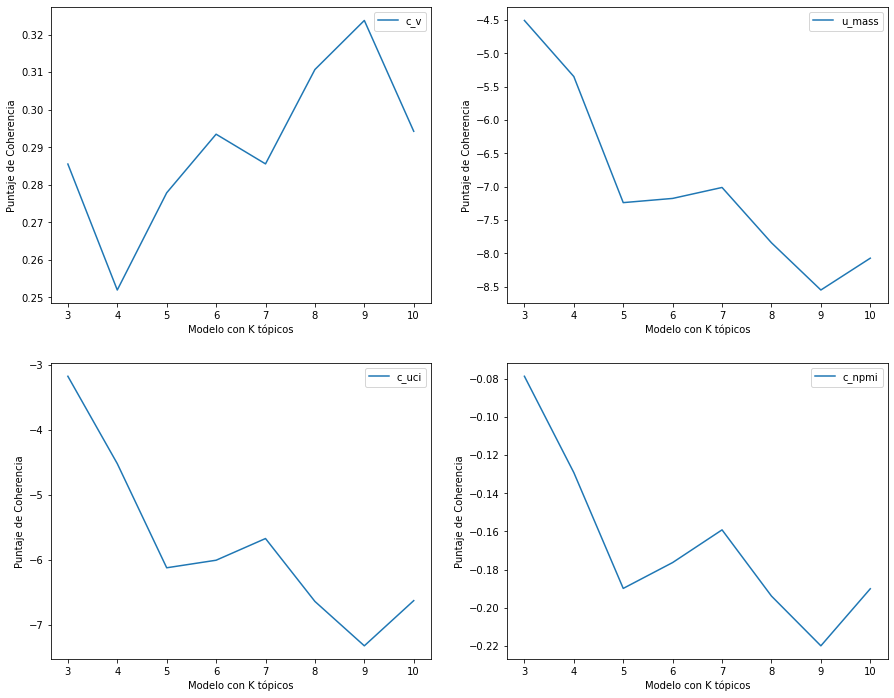

In [33]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

xvalues=["3","4","5","6","7","8","9","10"]


fig, ax = plt.subplots(2,2,figsize=(15,12))

df=pd.DataFrame({'xvalues': xvalues, 'yvalues': cv })
ax[0,0].plot( 'xvalues', 'yvalues', data=df, label="c_v")
ax[0,0].set_xlabel('Modelo con K tópicos')
ax[0,0].set_ylabel('Puntaje de Coherencia')
ax[0,0].legend()

df=pd.DataFrame({'xvalues': xvalues, 'yvalues': umass })
ax[0,1].plot( 'xvalues', 'yvalues', data=df, label="u_mass")
ax[0,1].set_xlabel('Modelo con K tópicos')
ax[0,1].set_ylabel('Puntaje de Coherencia')
ax[0,1].legend()


df=pd.DataFrame({'xvalues': xvalues, 'yvalues': cuci })
ax[1,0].plot( 'xvalues', 'yvalues', data=df, label="c_uci")
ax[1,0].set_xlabel('Modelo con K tópicos')
ax[1,0].set_ylabel('Puntaje de Coherencia')
ax[1,0].legend()

df=pd.DataFrame({'xvalues': xvalues, 'yvalues': cnpmi })
ax[1,1].plot( 'xvalues', 'yvalues', data=df, label="c_npmi")
ax[1,1].set_xlabel('Modelo con K tópicos')
ax[1,1].set_ylabel('Puntaje de Coherencia')
ax[1,1].legend()

plt.show()


In [34]:
#path_of_model = datapath(PATH+"model_"+str(8)+"_topics")
ldaseq = LdaSeqModel.load("D:/model_3_topics")

# 5. Análisis de la evolución del discurso

#### 5.1 Tópico 0

In [41]:
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)

In [42]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"ministro, 0.016","país, 0.015","presidente, 0.012","oposición, 0.01","crisis, 0.01","violaciones, 0.01","acusación, 0.009","forma, 0.009","parlamentarios, 0.008","diputado, 0.007","medidas, 0.006","proyecto, 0.006","proceso, 0.006","política, 0.006","documento, 0.005","responsabilidad, 0.005","informe, 0.005","marco, 0.005","pensiones, 0.005","violencia, 0.005","años, 0.005","gente, 0.005","manifestaciones, 0.005","partido, 0.004","diputados, 0.004","palabras, 0.004","millones, 0.004","personas, 0.004","ciudadanía, 0.004","estallido, 0.004","cambio, 0.004","comisión, 0.004","democracia, 0.004","demandas, 0.004","vida, 0.004"
slice 1,"país, 0.015","ministro, 0.013","presidente, 0.011","oposición, 0.01","crisis, 0.009","forma, 0.009","violaciones, 0.007","diputado, 0.007","parlamentarios, 0.007","medidas, 0.006","acusación, 0.006","proceso, 0.006","marco, 0.006","proyecto, 0.006","política, 0.006","pensiones, 0.006","palabras, 0.005","millones, 0.005","gente, 0.005","demandas, 0.005","ciudadanía, 0.005","informe, 0.005","años, 0.005","documento, 0.005","manifestaciones, 0.005","personas, 0.005","violencia, 0.004","partido, 0.004","diputados, 0.004","responsabilidad, 0.004","población, 0.004","reunión, 0.004","diputada, 0.004","vida, 0.004","democracia, 0.004"
slice 2,"país, 0.019","ministro, 0.017","presidente, 0.012","crisis, 0.01","oposición, 0.009","diputado, 0.007","forma, 0.007","proyecto, 0.007","palabras, 0.007","medidas, 0.007","violaciones, 0.006","pensiones, 0.006","marco, 0.006","ciudadanía, 0.006","proceso, 0.006","parlamentarios, 0.006","política, 0.005","acusación, 0.005","demandas, 0.005","años, 0.005","vida, 0.005","población, 0.005","personas, 0.005","gente, 0.005","cargo, 0.004","ley, 0.004","diputada, 0.004","reunión, 0.004","millones, 0.004","manifestaciones, 0.004","chilenos, 0.004","gabinete, 0.004","diputados, 0.004","tema, 0.004","democracia, 0.004"
slice 3,"país, 0.025","ministro, 0.016","presidente, 0.013","crisis, 0.009","palabras, 0.007","proyecto, 0.007","diputado, 0.007","oposición, 0.007","vida, 0.006","marco, 0.006","forma, 0.006","pensiones, 0.006","medidas, 0.006","política, 0.006","años, 0.006","personas, 0.006","ciudadanía, 0.005","violaciones, 0.005","población, 0.005","parlamentarios, 0.005","proceso, 0.005","chilenos, 0.005","diputada, 0.005","gabinete, 0.004","tema, 0.004","cargo, 0.004","ley, 0.004","derecho, 0.004","reunión, 0.004","demandas, 0.004","cambio, 0.004","acusación, 0.004","millones, 0.004","diputados, 0.004","gente, 0.004"
slice 4,"país, 0.021","ministro, 0.013","presidente, 0.013","proyecto, 0.009","palabras, 0.008","crisis, 0.006","diputado, 0.006","vida, 0.006","años, 0.006","personas, 0.006","diputada, 0.006","forma, 0.006","política, 0.006","pensiones, 0.006","marco, 0.006","población, 0.005","chilenos, 0.005","proceso, 0.005","tema, 0.005","oposición, 0.005","ley, 0.005","medidas, 0.005","derecho, 0.005","inversión, 0.005","parlamentarios, 0.005","ciudadanía, 0.004","violaciones, 0.004","cargo, 0.004","millones, 0.004","sistema, 0.004","recursos, 0.004","partido, 0.004","posibilidad, 0.004","críticas, 0.004","gente, 0.004"


####  Dar un nombre al tópico 0

"Ministro-presidente-oposición-crisis-vida" (?)

#### Visualizar la evolución de ciertas palabras en un tópico dado

In [63]:
keyword="ministro"
topic=0
xvalues1=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues1=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues1.append(newValue)

('ministro', 0.016170798071276936)
('ministro', 0.01348838904769043)
('ministro', 0.016699224083971613)
('ministro', 0.016251337205150835)
('ministro', 0.013357949491092803)


In [64]:
keyword="presidente"
topic=0
xvalues2=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues2=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues2.append(newValue)

('presidente', 0.011592463709655254)
('presidente', 0.010702898797578667)
('presidente', 0.011987038015282352)
('presidente', 0.01268600708486762)
('presidente', 0.012971699124141272)


In [65]:
keyword="oposición"
topic=0
xvalues3=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues3=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues3.append(newValue)

('oposición', 0.01013745694666837)
('oposición', 0.010033526404372193)
('oposición', 0.009174863977548622)
('oposición', 0.006781000903458557)
('oposición', 0.005237922582446443)


In [66]:
keyword="crisis"
topic=0
xvalues4=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues4=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues4.append(newValue)

('crisis', 0.009549133982881515)
('crisis', 0.009057041550949578)
('crisis', 0.009741883606534059)
('crisis', 0.008988639071869411)
('crisis', 0.006496293253233767)


In [67]:
keyword="vida"
topic=0
xvalues5=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues5=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=0,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues5.append(newValue)

('vida', 0.0037533655569008777)
('vida', 0.004024566822334886)
('vida', 0.004695823447268429)
('vida', 0.006109561803911195)
('vida', 0.006403293806345406)


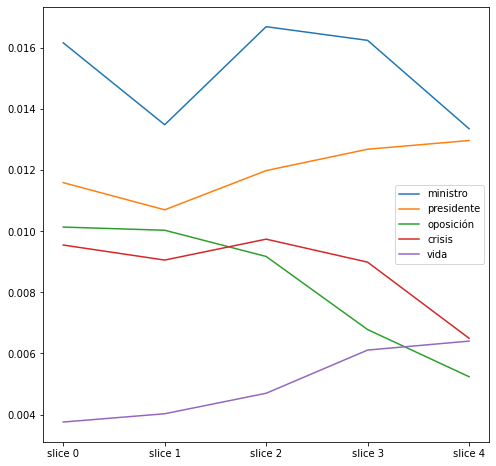

In [69]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,8) )

df=pd.DataFrame({'xvalues': xvalues1, 'yvalues': yvalues1 })
plt.plot( 'xvalues', 'yvalues', data=df, label="ministro")

df=pd.DataFrame({'xvalues': xvalues2, 'yvalues': yvalues2 })
plt.plot( 'xvalues', 'yvalues', data=df, label="presidente")

df=pd.DataFrame({'xvalues': xvalues3, 'yvalues': yvalues3 })
plt.plot( 'xvalues', 'yvalues', data=df, label="oposición")

df=pd.DataFrame({'xvalues': xvalues4, 'yvalues': yvalues4 })
plt.plot( 'xvalues', 'yvalues', data=df, label="crisis")

df=pd.DataFrame({'xvalues': xvalues5, 'yvalues': yvalues5 })
plt.plot( 'xvalues', 'yvalues', data=df, label="vida")

ax.legend()
plt.show()

#### 5.2 Tópico 1

In [51]:
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)

In [52]:
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"personas, 0.019","saqueos, 0.012","seguridad, 0.011","situación, 0.01","manifestaciones, 0.009","medida, 0.009","año, 0.007","jornada, 0.007","jefe, 0.007","estaciones, 0.007","país, 0.007","ataques, 0.006","semana, 0.006","información, 0.006","martes, 0.006","sector, 0.006","protestas, 0.005","transporte, 0.005","viernes, 0.005","servicio, 0.005","mañana, 0.005","violencia, 0.005","pasajeros, 0.005","miércoles, 0.005","alza, 0.005","comunas, 0.005","estallido, 0.005","comuna, 0.005","avión, 0.005","calles, 0.005","empresa, 0.005","incendios, 0.005","prensa, 0.004","responsabilidad, 0.004","lunes, 0.004"
slice 1,"personas, 0.016","saqueos, 0.011","manifestaciones, 0.01","situación, 0.01","medida, 0.01","seguridad, 0.009","estaciones, 0.008","jornada, 0.008","semana, 0.008","país, 0.007","año, 0.007","protestas, 0.006","miércoles, 0.006","servicio, 0.006","alza, 0.006","comunas, 0.006","mañana, 0.006","transporte, 0.006","violencia, 0.006","sector, 0.005","ataques, 0.005","jefe, 0.005","lunes, 0.005","martes, 0.005","comuna, 0.005","viernes, 0.005","calles, 0.005","daños, 0.005","responsabilidad, 0.005","información, 0.005","empresa, 0.005","capital, 0.004","autoridades, 0.004","incendios, 0.004","puntos, 0.004"
slice 2,"personas, 0.015","situación, 0.011","manifestaciones, 0.01","estaciones, 0.009","país, 0.009","medida, 0.009","jornada, 0.008","seguridad, 0.008","alza, 0.008","saqueos, 0.008","protestas, 0.007","semana, 0.007","servicio, 0.007","mañana, 0.007","comunas, 0.006","transporte, 0.006","viernes, 0.006","año, 0.006","lunes, 0.006","miércoles, 0.006","capital, 0.005","calles, 0.005","violencia, 0.005","autoridades, 0.005","daños, 0.005","comuna, 0.005","martes, 0.005","sábado, 0.005","regiones, 0.005","empresa, 0.004","responsabilidad, 0.004","sector, 0.004","puntos, 0.004","jefe, 0.004","condiciones, 0.004"
slice 3,"personas, 0.017","situación, 0.011","estaciones, 0.01","alza, 0.01","servicio, 0.009","manifestaciones, 0.009","jornada, 0.008","país, 0.008","medida, 0.008","comunas, 0.008","protestas, 0.007","mañana, 0.007","transporte, 0.007","seguridad, 0.006","lunes, 0.006","calles, 0.006","viernes, 0.006","semana, 0.006","capital, 0.006","saqueos, 0.006","sábado, 0.006","empresa, 0.005","puntos, 0.005","miércoles, 0.005","autoridades, 0.005","violencia, 0.005","toque, 0.005","regiones, 0.005","martes, 0.004","comuna, 0.004","año, 0.004","ciudad, 0.004","condiciones, 0.004","responsabilidad, 0.004","militares, 0.004"
slice 4,"personas, 0.016","situación, 0.009","servicio, 0.009","país, 0.009","estaciones, 0.008","jornada, 0.008","alza, 0.008","mañana, 0.008","comunas, 0.007","medida, 0.007","manifestaciones, 0.007","empresa, 0.006","protestas, 0.006","transporte, 0.006","sábado, 0.006","lunes, 0.006","semana, 0.006","viernes, 0.006","puntos, 0.005","seguridad, 0.005","calles, 0.005","capital, 0.005","regiones, 0.005","saqueos, 0.005","miércoles, 0.005","responsabilidad, 0.005","autoridades, 0.005","aplicación, 0.004","año, 0.004","violencia, 0.004","martes, 0.004","jueves, 0.004","ley, 0.004","ciudad, 0.004","comuna, 0.004"


####  Dar un nombre al tópico 1

"saqueos - manifestaciones - seguridad - servicio- alza" (?)

In [70]:
keyword="saqueos"
topic=1
xvalues1=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues1=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues1.append(newValue)

('saqueos', 0.011776947733301851)
('saqueos', 0.010743619824908573)
('saqueos', 0.007636687892105593)
('saqueos', 0.005851932343090877)
('saqueos', 0.004793257955210581)


In [71]:
keyword="manifestaciones"
topic=1
xvalues2=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues2=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues2.append(newValue)

('manifestaciones', 0.009495645480585674)
('manifestaciones', 0.010253740576078328)
('manifestaciones', 0.009769694889052497)
('manifestaciones', 0.008910574575830483)
('manifestaciones', 0.006670816533862395)


In [72]:
keyword="seguridad"
topic=1
xvalues3=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues3=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues3.append(newValue)

('seguridad', 0.010704993493323368)
('seguridad', 0.009438510954151373)
('seguridad', 0.007986453585415288)
('seguridad', 0.0064672615825652245)
('seguridad', 0.005375546797808967)


In [73]:
keyword="servicio"
topic=1
xvalues4=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues4=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues4.append(newValue)

('servicio', 0.005187296549351622)
('servicio', 0.005819780360525451)
('servicio', 0.006932600097101304)
('servicio', 0.009424930905117458)
('servicio', 0.009172318645659679)


In [74]:
keyword="alza"
topic=0
xvalues5=["slice 0","slice 1","slice 2", "slice 3", "slice 4"]
yvalues5=[]

for i in range(5):
    keywords=ldaseq.print_topic(topic=1,time=i,top_terms=1000)
    for k in keywords:
        newValue=0
        if (k[0] == keyword):
            newValue=k[1]
            print(k)
            break
    yvalues5.append(newValue)

('alza', 0.00474437446974337)
('alza', 0.00575821165519206)
('alza', 0.0076384061224256455)
('alza', 0.00986440829039389)
('alza', 0.007743323211649895)


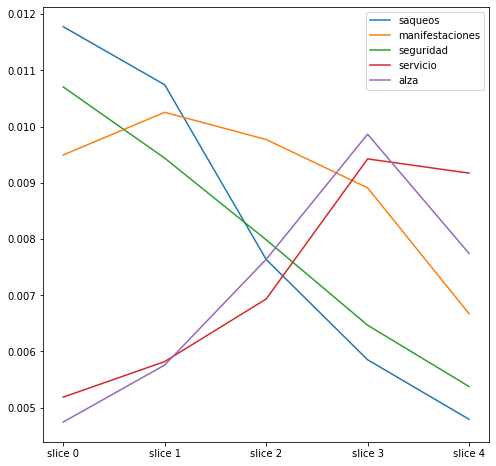

In [75]:
# libraries and data
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(8,8))

df=pd.DataFrame({'xvalues': xvalues1, 'yvalues': yvalues1 })
plt.plot( 'xvalues', 'yvalues', data=df, label="saqueos")

df=pd.DataFrame({'xvalues': xvalues2, 'yvalues': yvalues2 })
plt.plot( 'xvalues', 'yvalues', data=df, label="manifestaciones")

df=pd.DataFrame({'xvalues': xvalues3, 'yvalues': yvalues3 })
plt.plot( 'xvalues', 'yvalues', data=df, label="seguridad")

df=pd.DataFrame({'xvalues': xvalues4, 'yvalues': yvalues4 })
plt.plot( 'xvalues', 'yvalues', data=df, label="servicio")

df=pd.DataFrame({'xvalues': xvalues5, 'yvalues': yvalues5 })
plt.plot( 'xvalues', 'yvalues', data=df, label="alza")


ax.legend()
plt.show()

In [76]:
#### tópico 2 
table=[]
for i in range(5):
    row=["slice "+str(i)]
    keywords=ldaseq.print_topic(topic=2,time=i,top_terms=35)
    for keyword in keywords:
        row.append(str(keyword[0])+", "+str(round(keyword[1],3)))
    table.append(row)
    
from IPython.display import HTML, display
import tabulate

display(HTML(tabulate.tabulate(table, tablefmt='html')))

slice 0,"personas, 0.016","años, 0.014","hechos, 0.012","caso, 0.01","delito, 0.01","joven, 0.009","investigación, 0.008","delitos, 0.008","comuna, 0.007","funcionarios, 0.006","institución, 0.006","apoyo, 0.006","información, 0.006","casos, 0.006","tipo, 0.005","interior, 0.005","año, 0.005","muerte, 0.005","manifestaciones, 0.005","antecedentes, 0.005","carabineros, 0.005","víctima, 0.005","redes, 0.004","incendio, 0.004","lesiones, 0.004","familia, 0.004","casa, 0.004","perdigones, 0.004","seguridad, 0.004","sector, 0.004","forma, 0.004","armas, 0.004","prisión, 0.004","acciones, 0.004","orden, 0.004"
slice 1,"personas, 0.015","años, 0.014","joven, 0.01","hechos, 0.01","caso, 0.009","delito, 0.008","comuna, 0.007","investigación, 0.007","funcionarios, 0.007","delitos, 0.007","carabineros, 0.006","institución, 0.006","manifestaciones, 0.006","antecedentes, 0.006","tipo, 0.006","perdigones, 0.006","interior, 0.005","información, 0.005","casos, 0.005","víctima, 0.005","apoyo, 0.005","redes, 0.005","personal, 0.005","muerte, 0.005","incendio, 0.005","forma, 0.005","año, 0.005","familia, 0.005","armas, 0.004","seguridad, 0.004","casa, 0.004","prisión, 0.004","orden, 0.004","acciones, 0.004","director, 0.004"
slice 2,"personas, 0.017","años, 0.011","hechos, 0.011","funcionarios, 0.009","joven, 0.008","caso, 0.008","delito, 0.008","comuna, 0.008","delitos, 0.007","investigación, 0.007","antecedentes, 0.006","apoyo, 0.006","información, 0.006","víctima, 0.006","carabineros, 0.006","manifestaciones, 0.006","tipo, 0.006","interior, 0.005","redes, 0.005","casos, 0.005","perdigones, 0.005","forma, 0.005","institución, 0.005","incendio, 0.005","seguridad, 0.005","familia, 0.004","personal, 0.004","fiscal, 0.004","año, 0.004","lesiones, 0.004","casa, 0.004","gravedad, 0.004","armas, 0.004","autoridad, 0.004","situación, 0.004"
slice 3,"personas, 0.016","años, 0.013","hechos, 0.011","funcionarios, 0.009","caso, 0.009","antecedentes, 0.008","comuna, 0.008","delito, 0.007","delitos, 0.007","investigación, 0.007","forma, 0.007","joven, 0.006","tipo, 0.006","víctima, 0.006","información, 0.006","redes, 0.006","apoyo, 0.005","lesiones, 0.005","casos, 0.005","autoridad, 0.005","manifestaciones, 0.005","interior, 0.005","carabineros, 0.005","seguridad, 0.004","personal, 0.004","incendio, 0.004","institución, 0.004","familia, 0.004","fiscal, 0.004","acceso, 0.004","hombre, 0.004","casa, 0.004","niños, 0.004","año, 0.004","edad, 0.004"
slice 4,"años, 0.013","personas, 0.011","investigación, 0.01","hechos, 0.009","antecedentes, 0.009","caso, 0.009","delito, 0.009","delitos, 0.008","comuna, 0.007","funcionarios, 0.007","forma, 0.006","información, 0.006","tipo, 0.006","joven, 0.006","víctima, 0.006","autoridad, 0.006","redes, 0.005","casos, 0.005","casa, 0.005","apoyo, 0.005","familia, 0.005","fiscal, 0.005","lesiones, 0.005","personal, 0.004","niños, 0.004","víctimas, 0.004","denuncia, 0.004","atención, 0.004","homicidio, 0.004","interior, 0.004","año, 0.004","mujer, 0.004","incendio, 0.004","acceso, 0.004","seguridad, 0.004"


In [ ]:
####  Dar un nombre al tópico 2

"hechos - funcionarios - joven - delito - investigación" (?)

- Topico 0 = "Palabras del Presidente y políticos"
- Topico 1 = "Manifestaciones"
- Topico 2 = "Delitos"

**Ejercicio 2:**
1) Complete el análisis del tópico 2
2) Repita el ejercicio con 7 tópicos y compare sus resultados.


**Ejercicio 3:**

1) ¿Cuáles son las limitaciones del protocolo utilizado? ¿Qué se podría mejorar?

2) A partir de este conjunto de noticias ¿Cómo interpreta lo que pasó entre el 4 de octubre y 13 de diciembre? ¿Cómo se podría continuar el análisis para obtener conclusiones más precisas?